In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

In [5]:
df = pd.read_json('DiSmldata.json')

In [6]:
#Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(df[['hash_count', 'emoji_count','clean_text',
                                                        'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']], df['label'],test_size =0.20, random_state = 77)

In [7]:
my_stop_words = ENGLISH_STOP_WORDS.union(['disneyland','tokyo','disney', 'im', 'tdrnow','paris','california','amp','disneysea','got',
                                         'ºc', 'ºf', 'ºoº','𝗧𝗵𝗲','くまのプーさん', 'ディズニー', 'ディズニーシー','ディズニーハロウィーン',
                                         'ディズニーランド', 'ディズニー好きと繋がりたい', 'フェスティバルオブミスティーク', 'マルマン',
                                         'ㅋㅋㅋ', '場所', '更新', '月released', '東京ディズニーシー', '東京ディズニーランド', '東京ディズニーリゾート',
                                         '香港迪士尼樂園', 'ºº', 'hong', 'kong',"disneylandresort", "disneyland", "disneyresort",
                                          "californiaadventure",'downtowndisney','disneyanaheim','disneylandanaheim',
                                          'disneycalifornia','californiadisney','disneysea', 'disneytokyo', 'disneytokyoresort', 
                                          'tokyodisney','tokyodisneyresort', 'tokyodisneyland','東京ディズニーランド', 'ディズニーランド',
                                          '東京ディズニーシー', 'ズニーシー', 'tdr_now', 'tdr_md','tdr','dca','dl'])

In [5]:
#min_df and max_df

In [6]:
def make_xy(df, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.clean_text)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.label
    return X, y
X, y = make_xy(df)

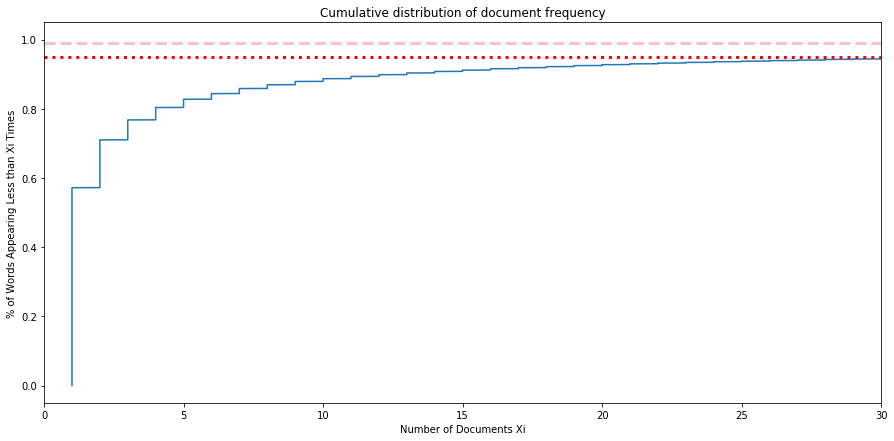

In [7]:
data = np.sum(X>0,axis=0)
sorted_df = np.sort(data).reshape(-1,1)
yvals=np.arange(len(sorted_df))/float(len(sorted_df)-1)
plt.figure(figsize = (15,7))
plt.plot(sorted_df,yvals)
plt.xlim([0,30])
plt.axhline(0.95, c = 'red', linestyle = ':', linewidth = 3)
plt.axhline(0.99, c = 'pink', linestyle = '--', linewidth =3)
plt.xlabel('Number of Documents Xi')
plt.ylabel('% of Words Appearing Less than Xi Times')
plt.title('Cumulative distribution of document frequency')
plt.show()

In [ ]:
#Set to 25 max_df 3 min_df

In [8]:
#Count vectorizer Document term matrix

count_vecto = CountVectorizer(stop_words = my_stop_words, min_df = 3, max_df = 25)
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [9]:
X_train_vect.shape

(70008, 10910)

In [10]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [11]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB(alpha = 0.05)

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 498.906 / Predict time: 5.593 ---- Precision: 0.409 / Recall: 0.458 / Accuracy: 0.458


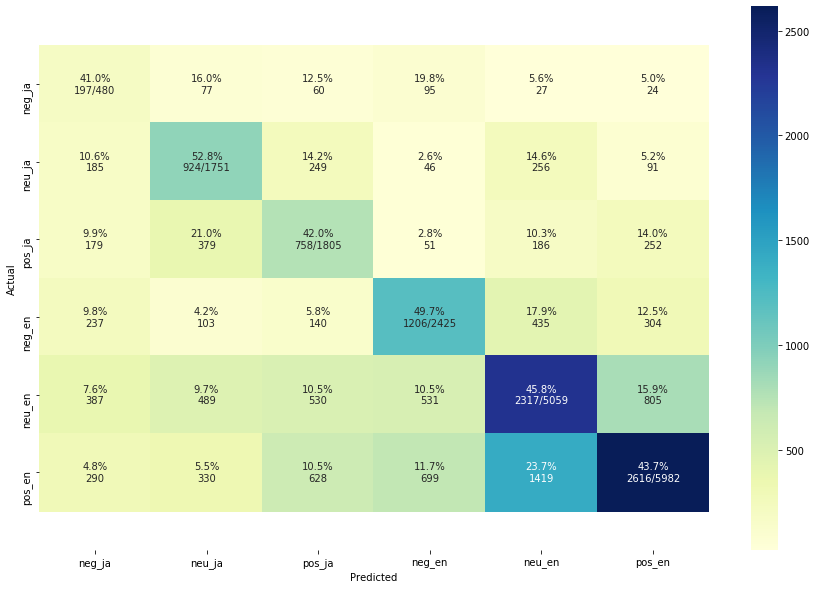

In [12]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_test, y_pred)
plt.show()

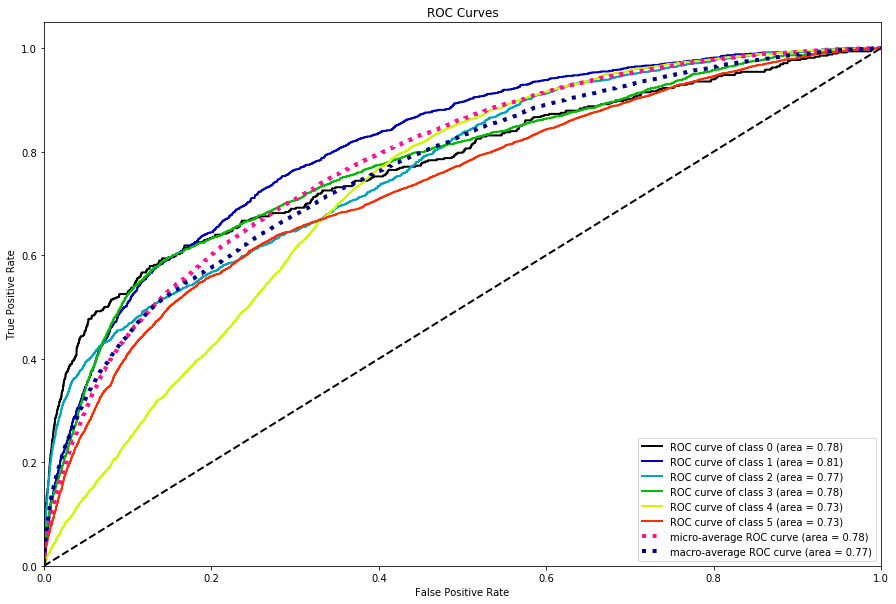

In [15]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = nb_clf.predict_proba(X_test_vect)
scikitplot.metrics.plot_roc(y_test, y_pred_proba, figsize=(15,10))
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score

y_prob = nb_clf.predict_proba(X_test_vect)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.778450 (macro),
0.772992 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.766201 (macro),
0.750488 (weighted by prevalence)


In [ ]:
#Max Features

In [41]:
#Count vectorizer Document term matrix similar to min and max df

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 10900)
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [42]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [43]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB(alpha = 0.05)

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 528.981 / Predict time: 5.164 ---- Precision: 0.621 / Recall: 0.664 / Accuracy: 0.681


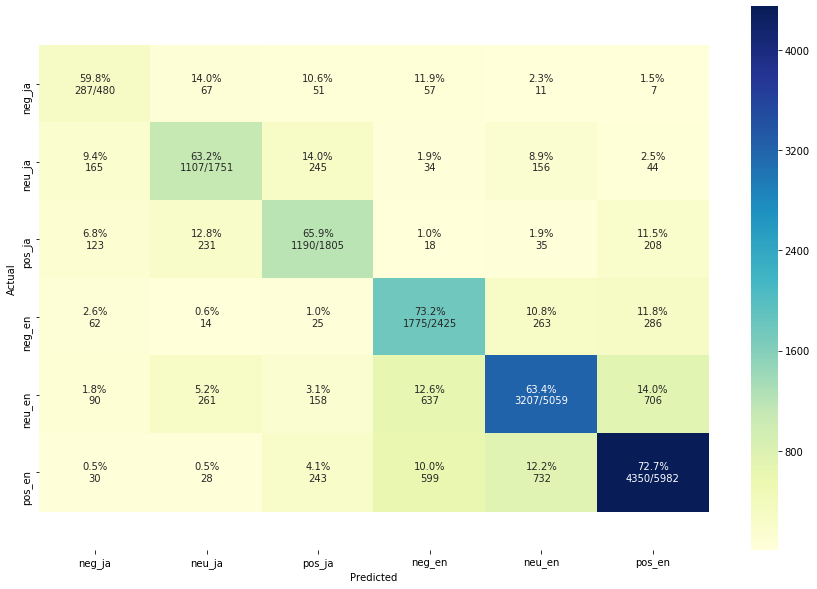

In [44]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_test, y_pred)
plt.show()

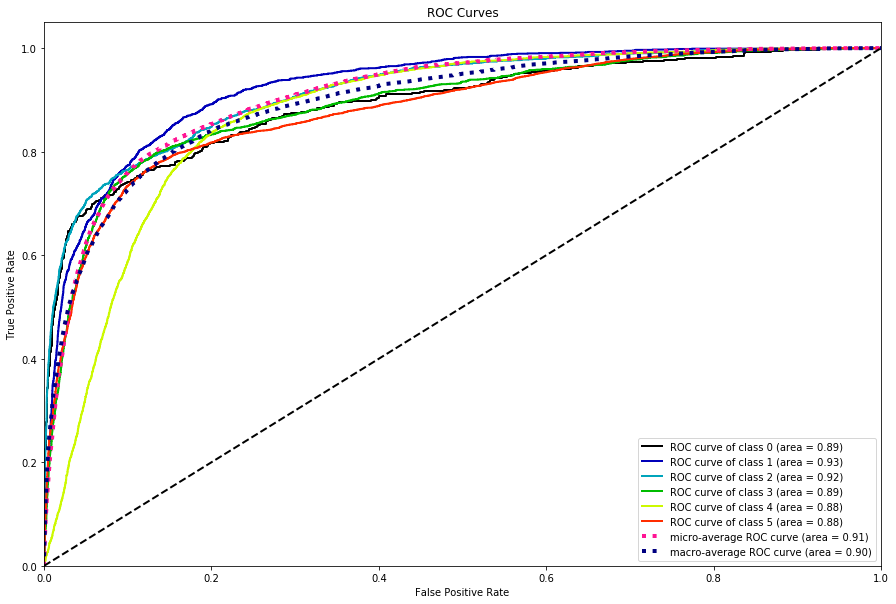

In [45]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = nb_clf.predict_proba(X_test_vect)
scikitplot.metrics.plot_roc(y_test, y_pred_proba, figsize=(15,10))
plt.show()

In [46]:
from sklearn.metrics import roc_auc_score

y_prob = nb_clf.predict_proba(X_test_vect)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.901758 (macro),
0.903071 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.898127 (macro),
0.890546 (weighted by prevalence)


In [ ]:
#Testing out different Max Features 

In [2]:
def nb_feat(features):
    cv = CountVectorizer(stop_words = my_stop_words, max_features = features)
    cv_fit = cv.fit(X_train['clean_text'])
    cv_train = cv_fit.transform(X_train['clean_text'])
    cv_test = cv_fit.transform(X_test['clean_text'])
    X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(cv_train.toarray())], axis=1)
    X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(cv_test.toarray())], axis=1)
   
    #Balance
    ros = ros = RandomOverSampler(random_state=77)
    X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
    
    #Instantiate our model 
    nb_clf = MultinomialNB(alpha = 0.05)

    #Model Fit 
    start = time.time()
    nb_clf.fit(X_resampled_ros, y_resampled_ros)
    end = time.time()
    fit_time = (end - start)

    #Model Predict 
    start = time.time()
    y_pred = nb_clf.predict(X_test_vect)
    end = time.time()
    pred_time = (end - start)

    #Model Scoring 
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

In [8]:
#Count vectorizer 3000
nb_feat(3000)

Fit time: 61.811 / Predict time: 1.024 ---- Precision: 0.59 / Recall: 0.645 / Accuracy: 0.658


In [10]:
#Count vectorizer Document term matrix of 5000
nb_feat(5000)

Fit time: 124.741 / Predict time: 1.999 ---- Precision: 0.606 / Recall: 0.657 / Accuracy: 0.67


In [11]:
#Count Vectorizer 7000
nb_feat(7000)

Fit time: 212.709 / Predict time: 3.106 ---- Precision: 0.614 / Recall: 0.662 / Accuracy: 0.676


In [12]:
#Count Vectorizer(10000)
nb_feat(10000)

Fit time: 363.384 / Predict time: 6.072 ---- Precision: 0.62 / Recall: 0.665 / Accuracy: 0.68


In [13]:
#Count Vectorizer(15000)
nb_feat(15000)

Fit time: 606.974 / Predict time: 7.75 ---- Precision: 0.621 / Recall: 0.662 / Accuracy: 0.68


In [14]:
#Count Vectorizer(20000)
nb_feat(20000)

Fit time: 842.056 / Predict time: 10.104 ---- Precision: 0.622 / Recall: 0.661 / Accuracy: 0.681


In [ ]:
# Fit time: 61.811 / Predict time: 1.024 ---- Precision: 0.59 / Recall: 0.645 / Accuracy: 0.658
# Fit time: 124.741 / Predict time: 1.999 ---- Precision: 0.606 / Recall: 0.657 / Accuracy: 0.67
# Fit time: 212.709 / Predict time: 3.106 ---- Precision: 0.614 / Recall: 0.662 / Accuracy: 0.676
# Fit time: 363.384 / Predict time: 6.072 ---- Precision: 0.62 / Recall: 0.665 / Accuracy: 0.68
# Fit time: 528.981 / Predict time: 5.164 ---- Precision: 0.621 / Recall: 0.664 / Accuracy: 0.681
# Fit time: 606.974 / Predict time: 7.75 ---- Precision: 0.621 / Recall: 0.662 / Accuracy: 0.68
#Fit time: 842.056 / Predict time: 10.104 ---- Precision: 0.622 / Recall: 0.661 / Accuracy: 0.681

In [15]:
nb_table = pd.DataFrame()
nb_table['train_time'] = [61.811, 124.741, 212.709, 363.384, 528.981, 606.974, 842.056]
nb_table['features'] = [3000, 5000, 7000, 10000, 10900, 15000, 20000]
nb_table['accuracy_score'] = [0.658, 0.67, 0.676, 0.68, 0.681, 0.68, 0.681]
nb_table['precision'] =  [0.59, 0.606, 0.614, 0.62, 0.621, 0.621, 0.622]
nb_table['recall'] = [0.645, 0.657, 0.662, 0.665, 0.664, 0.662, 0.661]

In [16]:
nb_table

,train_time,features,accuracy_score,precision,recall
0,61.811,3000,0.658,0.590,0.645
1,124.741,5000,0.670,0.606,0.657
2,212.709,7000,0.676,0.614,0.662
3,363.384,10000,0.680,0.620,0.665
4,528.981,10900,0.681,0.621,0.664
5,606.974,15000,0.680,0.621,0.662
6,842.056,20000,0.681,0.622,0.661


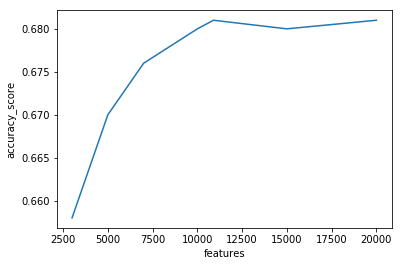

In [17]:
#lineplots
sns.lineplot(nb_table['features'], nb_table['accuracy_score'])
plt.show()

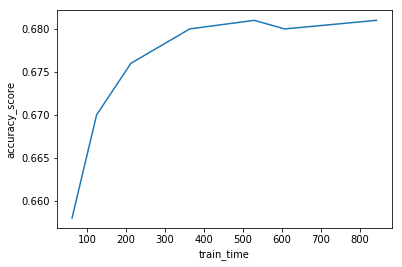

In [20]:
#lineplots
sns.lineplot(nb_table['train_time'], nb_table['accuracy_score'])
plt.show()

In [ ]:
#Looks to be at 10000 features should be the best model 

In [ ]:
#Choosing the best model 

In [21]:
#Count vectorizer Document term matrix similar to min and max df

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 10000)
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [22]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB(alpha = 0.05)

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 365.804 / Predict time: 3.768 ---- Precision: 0.62 / Recall: 0.665 / Accuracy: 0.68


In [23]:
from sklearn.metrics import classification_report
target_names = ['ja_neg', 'ja_neu', 'ja_pos', 'en_neg', 'en_neu', 'en_pos']
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

      ja_neg       0.38      0.61      0.47       480
      ja_neu       0.64      0.63      0.64      1751
      ja_pos       0.63      0.66      0.64      1805
      en_neg       0.57      0.74      0.64      2425
      en_neu       0.72      0.63      0.67      5059
      en_pos       0.78      0.72      0.75      5982

    accuracy                           0.68     17502
   macro avg       0.62      0.67      0.64     17502
weighted avg       0.69      0.68      0.68     17502



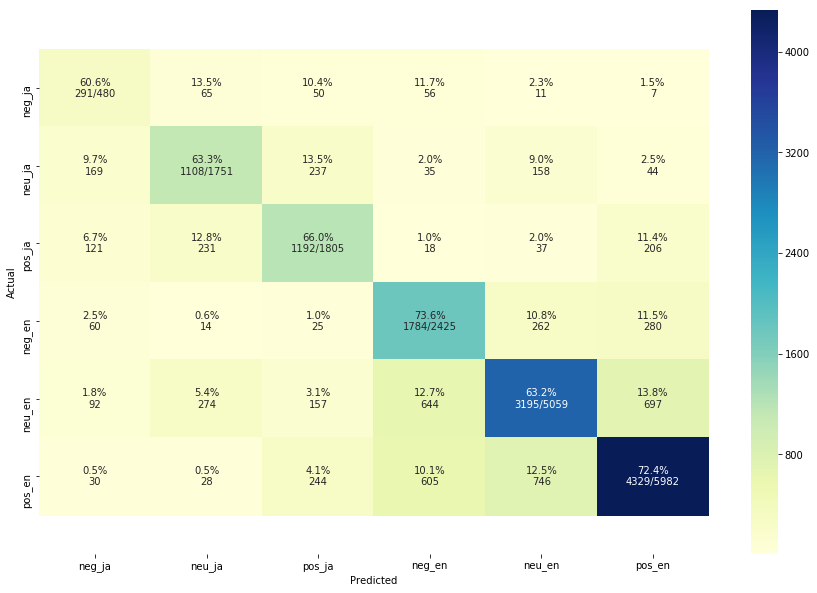

In [24]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_test, y_pred)
plt.show()

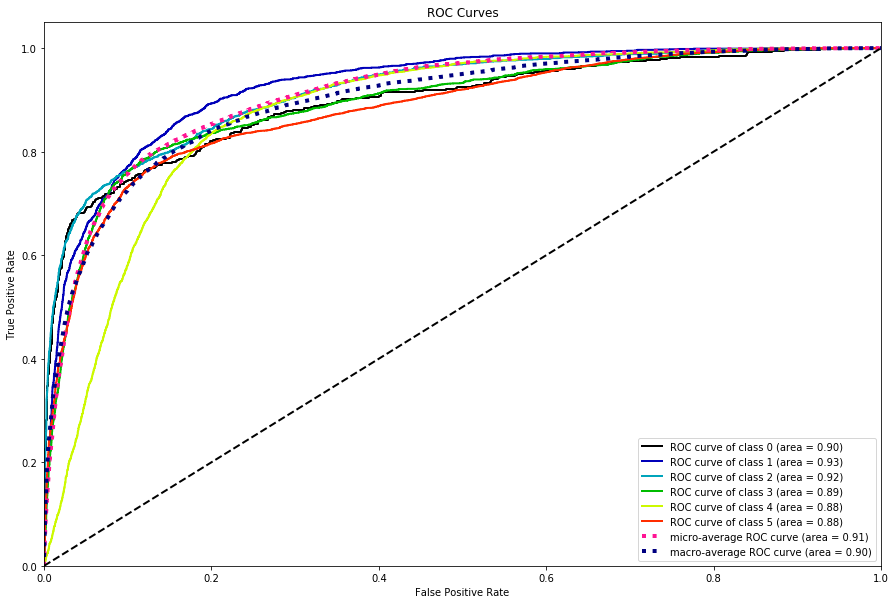

In [25]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = nb_clf.predict_proba(X_test_vect)
scikitplot.metrics.plot_roc(y_test, y_pred_proba, figsize=(15,10))
plt.show()

In [26]:
from sklearn.metrics import roc_auc_score

y_prob = nb_clf.predict_proba(X_test_vect)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.902139 (macro),
0.903126 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.898290 (macro),
0.890273 (weighted by prevalence)
